In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import sys
import string
import nltk
import os
import glob
import pickle
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
!pip install transformers
import transformers
from transformers import pipeline
!pip install langdetect
from langdetect import detect
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=98e3ba89284a85ae5bd33d3e94afb127e67bfbccabbaf737fb319edaa9df0923
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


#[2019]
---

#QUESTION 1

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

def remove_punctuation(input_string):
   # Make a translator object that will replace all punctuation with a space
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

    # Use the translator object to remove punctuation from the input string
    no_punct = input_string.translate(translator)
    return no_punct

def remove_stopwords(input_string):
    if not isinstance(input_string, str):
        input_string = ' '.join(input_string)
    tokens = input_string.split()
    no_stop = [word for word in tokens if not word in stop_words]
    return ' '.join(no_stop)

def lemmatize_words(input_string):
    tokens = input_string.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.




```
Preprocessing the reviews file
```



In [4]:
# give the file paths
reviews_path_febrouary = '/content/drive/MyDrive/ΤΕΔΕ/2019/febrouary/reviews.csv'
reviews_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2019/march/reviews.csv'
reviews_path_april = '/content/drive/MyDrive/ΤΕΔΕ/2019/april/reviews.csv'

os.makedirs('2019', exist_ok=True)

# select the columns that we want to use for the results
columns_to_select = ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments' ]

# Read the CSV files into dataframes
df_reviews_febrouary = pd.read_csv(reviews_path_febrouary, usecols=columns_to_select)
df_reviews_march = pd.read_csv(reviews_path_march, usecols=columns_to_select)
df_reviews_april = pd.read_csv(reviews_path_april, usecols=columns_to_select)

df_reviews_febrouary  = df_reviews_febrouary.iloc[:50000]
df_reviews_march   = df_reviews_march.iloc[:50000]
df_reviews_april  = df_reviews_april.iloc[:50000]

# Merge the data from the three months
df_reviews = pd.concat([df_reviews_febrouary, df_reviews_march, df_reviews_april], ignore_index=True)

# Convert all values in 'comments' column to string
df_reviews['comments'] = df_reviews['comments'].astype(str)

# Decapitalize the text
df_reviews['comments'] = df_reviews['comments'].str.lower()

df_reviews['comments'] = df_reviews['comments'].replace(r'[^\w\s,]', ' ', regex=True)
#remove punctuation
df_reviews['comments'] = df_reviews['comments'].apply(remove_punctuation)
# Convert all values in 'comments' column to string and remove non-ASCII characters
df_reviews['comments'] = df_reviews['comments'].astype(str).apply(lambda x: x.encode("ascii", "ignore").decode())
# Tokenization
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: x.split())
# Drop rows where 'comments' column only contains one word
df_reviews = df_reviews[df_reviews['comments'].apply(lambda x: len(x) > 1)]
#remove stopwords
df_reviews['comments'] = df_reviews['comments'].apply(remove_stopwords)
#lemmatization
df_reviews['comments'] = df_reviews['comments'].apply(lemmatize_words)

#drop non words
df_reviews = df_reviews[df_reviews['comments'].str.contains(r'[a-zA-Z]', na=False)]

# Drop rows where 'listing_id' column doesn't contain a number made from the digits 1-9
df_reviews = df_reviews[df_reviews['listing_id'].astype(str).str.contains(r'^[1-9]+$', na=False)]


# Load the positive and negative words
with open('/content/drive/MyDrive/TEDE/positive_words.txt', 'r') as f:
    positive_words = set(f.read().splitlines())
with open('/content/drive/MyDrive/TEDE/negative_words.txt', 'r') as f:
    negative_words = set(f.read().splitlines())

# Create empty lists for positive, negative, and neutral comments
positive_rows = []
negative_rows = []
neutral_rows = []

# Iterate over each row in the DataFrame
for index, row in df_reviews.iterrows():
    comment_words = set(row['comments'].split())
    if comment_words & positive_words:

        positive_rows.append(row.to_dict())
    elif comment_words & negative_words:

        negative_rows.append(row.to_dict())
    else:
        neutral_rows.append(row.to_dict())

# Create DataFrames from the lists of dictionaries
positive_df = pd.DataFrame(positive_rows)
positive_df = positive_df.iloc[:1000]

negative_df = pd.DataFrame(negative_rows)
negative_df = negative_df.iloc[:2000]

neutral_df = pd.DataFrame(neutral_rows)
neutral_df = neutral_df.iloc[:6000]

df_reviews = pd.concat([positive_df, negative_df, neutral_df], ignore_index=True)

df_reviews = df_reviews.iloc[:9000]

# Apply the function to the 'comments' column
df_reviews['language'] = df_reviews['comments'].apply(detect_language)

# Filter out rows where language is not English
df_reviews = df_reviews[df_reviews['language'] == 'en']

# Drop rows where 'comments' column is empty or contains only whitespace
df_reviews = df_reviews[df_reviews['comments'].str.strip().astype(bool)]

# Drop the 'language' column
df_reviews = df_reviews.drop(columns=['language'])

# create the output file
df_reviews.to_csv(f'2019/reviews_output_2019.csv', index=False)



```
Create the test.tsv and the train.tsv
```



In [5]:
# Load your data
df = pd.read_csv('2019/reviews_output_2019.csv', sep='\t')

# Split your data
test_df, train_df = train_test_split(df, test_size=0.8, random_state=42)

# Write the split data to new TSV files
train_df.to_csv('2019/train_2019.tsv', sep='\t', index=False)
test_df.to_csv('2019/test_2019.tsv', sep='\t', index=False)


```
Sentiment analysis
```


In [6]:
# Initialize the sentiment analysis pipeline with the specified model
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the cleaned reviews
df_reviews = pd.read_csv('2019/reviews_output_2019.csv')
#df_reviews = df_reviews.iloc[:600]

# Apply the pipeline to the 'comments' column to get the sentiment analysis results
df_reviews['sentiment_result'] = df_reviews['comments'].apply(lambda x: sentiment_analysis(x[:512])[0])

# Extract the sentiment label and score from the results
df_reviews['sentiment_label'] = df_reviews['sentiment_result'].apply(lambda x: x['label'])

# Create a new dataframe with the 'id', 'comments', and 'sentiment' columns
df_sentiment = df_reviews[['id', 'comments', 'sentiment_label']]

# Save the new dataframe to a CSV file
df_sentiment.to_csv('2019/sentiment_output_2019.csv', index=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Positive: 53.89%
Negative: 27.06%
Neutral: 19.06%


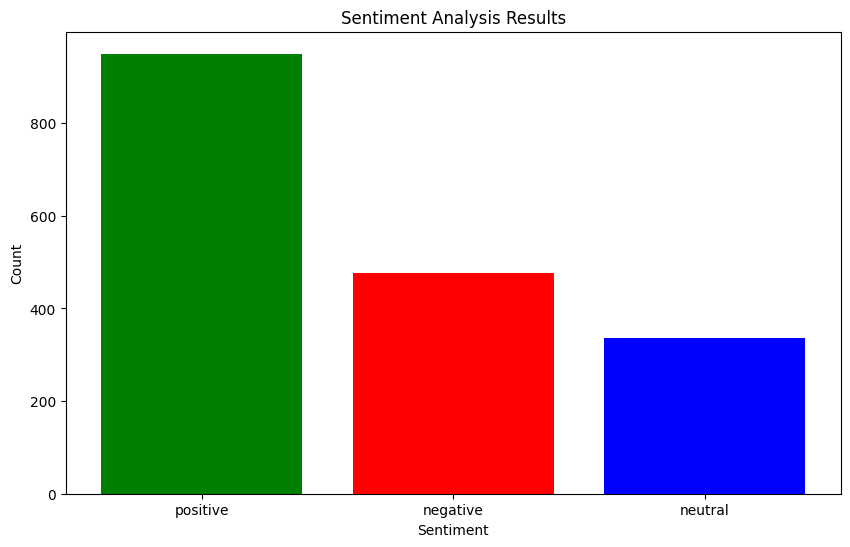

In [7]:
# Load the final CSV file
df_final = pd.read_csv('2019/sentiment_output_2019.csv')

# Count the number of each sentiment label
sentiment_counts = df_final['sentiment_label'].value_counts()

# Calculate the total number of sentiments
total_sentiments = sentiment_counts.sum()

# Calculate the percentage of each sentiment
sentiment_percentages = sentiment_counts / total_sentiments * 100

# Print the percentages
print(f"Positive: {sentiment_percentages['positive']:.2f}%")
print(f"Negative: {sentiment_percentages['negative']:.2f}%")
print(f"Neutral: {sentiment_percentages['neutral']:.2f}%")

# Create a bar plot of the sentiment counts
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')
plt.show()


#QUESTION 2

In [8]:
# Initialize the sentiment analysis pipeline with the specified model
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the cleaned reviews
train_df = pd.read_csv('2019/train_2019.tsv', sep=',')
#df_reviews = df_reviews.iloc[:600]

# Apply the pipeline to the 'comments' column to get the sentiment analysis results
train_df['sentiment_result'] = train_df['comments'].apply(lambda x: sentiment_analysis(x[:512])[0])

# Extract the sentiment label and score from the results
train_df['sentiment_label'] = train_df['sentiment_result'].apply(lambda x: x['label'])

# Create a new dataframe with the 'id', 'comments', and 'sentiment' columns
df_sentiment = df_reviews[['id', 'comments', 'sentiment_label']]

# Save the new dataframe to a CSV file
df_sentiment.to_csv('2019/train_2019.tsv', index=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



```
Χρήση train.tsv για την δημιουργία TF-IDF πίνακα και Word Embeddings
```


In [9]:
#Creation of TF-IDF matrix from the trained data of train.tsv

# Load the train.tsv file
df_train_tf = pd.read_csv('2019/train_2019.tsv', sep=',')

# Extract the 'comments' column
comments_train = df_train_tf['comments']

# Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'comments' data
tfidf_matrix_train = vectorizer.fit_transform(comments_train)

# Save the TfidfVectorizer to a pickle file
with open('2019/tfidf_vectorizer_2019.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


#Creation of wordembeddings from the trained data of train.tsv

# Load the train.tsv file
df_train_we = pd.read_csv('2019/train_2019.tsv', sep=',')

# Extract the 'comments' column
comments_train = df_train_we['comments']

# Tokenize the 'comments' data
tokenized_comments_train = [word_tokenize(comment) for comment in comments_train]

# Initialize a Word2Vec model
model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)

# Train the Word2Vec model
model.build_vocab(tokenized_comments_train)
model.train(tokenized_comments_train, total_examples=model.corpus_count, epochs=model.epochs)

# Save the Word2Vec model to a pickle file
with open('2019/word2vec_model_2019.pkl', 'wb') as f:
    pickle.dump(model, f)


#`SVM`


```
Classifier `SVM` trained by the `TF-IDF`

```


In [10]:
#Training the classifier with the tf-idf matrix

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_tf['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the SVM classifier
clf = svm.SVC(C=1.0, kernel='linear', gamma='scale')

# Train the SVM classifier using your training data
clf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)


Validation Accuracy: 0.9518413597733711



```
Actual labels of test.tsv
```

In [11]:
# Load the TSV file
df_reviews = pd.read_csv('2019/test_2019.tsv', sep=',')

# Apply the pipeline to the 'comments' column to get the sentiment analysis results
df_reviews['sentiment_result'] = df_reviews['comments'].apply(lambda x: sentiment_analysis(x[:512])[0])

# Extract the sentiment label from the results
df_reviews['sentiment_label'] = df_reviews['sentiment_result'].apply(lambda x: x['label'])

# Create a new dataframe with the 'id', 'comments', and 'sentiment' columns
df_sentiment = df_reviews[['id', 'comments', 'sentiment_label']]

# Save the new dataframe to a CSV file
df_sentiment.to_csv('2019/sentiment_output2_2019.csv', index=False)


```
Classifier `SVM` trained by the `Word embeddings`
```


In [12]:
# Load the Word2Vec model
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    model = pickle.load(f)

# Convert the tokenized comments into vectors
vectorized_comments_train = [model.wv[comment] for comment in tokenized_comments_train]

# Average the word vectors for each comment to get a single vector per comment
vectorized_comments_train = [np.mean(comment, axis=0) for comment in vectorized_comments_train]

# Load the train.tsv file
df_train_we = pd.read_csv('2019/train_2019.tsv', sep=',')

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_we['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(vectorized_comments_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the SVM classifier
clf = svm.SVC(C=1.0, kernel='linear', gamma='scale')

# Train the SVM classifier using your training data
clf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.7847025495750708



```
`10-fold Cross` Validation `Word embeddings`
```


In [13]:
# Load the CSV file
df = pd.read_csv('2019/sentiment_output2_2019.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Load your word embeddings
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    word_embeddings = pickle.load(f)

# Transform the comments into word embeddings
X = np.array([np.mean([word_embeddings.wv[word] for word in comment.split() if word in word_embeddings.wv], axis=0) for comment in X])

# Initialize the classifier
clf = SVC(C=1.0, kernel='linear', gamma='scale')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7856294930742136 Recall: 0.8098412698412698 F1 score: 0.7669380590965097 Accuracy: 0.8098412698412698
   Precision    Recall  F1 Score  Accuracy
0   0.848889  0.777778  0.722663  0.777778
1   0.745169  0.777778  0.727778  0.777778
2   0.861039  0.828571  0.798046  0.828571
3   0.652174  0.771429  0.702857  0.771429
4   0.635429  0.742857  0.677321  0.742857
5   0.765839  0.771429  0.753176  0.771429
6   0.878912  0.857143  0.823354  0.857143
7   0.900557  0.885714  0.866834  0.885714
8   0.641758  0.771429  0.691456  0.771429
9   0.926531  0.914286  0.905894  0.914286



```
`10-fold Cross` Validation `TF-IDF`
```


In [14]:
# Load the CSV file
df = pd.read_csv('2019/sentiment_output2_2019.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Transform the comments into TF-IDF vectors
with open('2019/tfidf_vectorizer_2019.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
X = vectorizer.transform(X)

# Initialize the classifier
clf = SVC(C=1.0, kernel='linear', gamma='scale')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)


# Calculate cross-validation scores
precision = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.8770685964236143 Recall: 0.8694444444444445 F1 score: 0.8577410242398935 Accuracy: 0.8694444444444445
   Precision    Recall  F1 Score  Accuracy
0   0.861947  0.861111  0.858907  0.861111
1   0.832011  0.833333  0.814327  0.833333
2   0.898571  0.885714  0.877501  0.885714
3   0.817687  0.828571  0.803308  0.828571
4   0.889524  0.885714  0.884673  0.885714
5   0.868707  0.857143  0.856166  0.857143
6   0.878912  0.857143  0.823354  0.857143
7   0.922597  0.914286  0.904781  0.914286
8   0.888199  0.857143  0.842245  0.857143
9   0.912531  0.914286  0.912147  0.914286


#`Random Forests`


```
Classifier `Random Forests` trained by the `TF-IDF`
```


In [15]:
# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

df_train_tf = pd.read_csv('2019/train_2019.tsv', sep=',')

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_tf['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Train the Random Forest classifier using your training data
clf_rf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_rf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.9603399433427762



```
Classifier `Ramdom Forests` trained by the `Word embeddings`
```


In [16]:
# Load the Word2Vec model
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    model = pickle.load(f)

# Convert the tokenized comments into vectors
vectorized_comments_train = [model.wv[comment] for comment in tokenized_comments_train]

# Average the word vectors for each comment to get a single vector per comment
vectorized_comments_train = [np.mean(comment, axis=0) for comment in vectorized_comments_train]

# Extract the 'sentiment_label' column
sentiment_labels_train = df_sentiment['sentiment_label']

# Ensure that vectorized_comments_train and sentiment_labels_train have the same length
if len(vectorized_comments_train) != len(sentiment_labels_train):
    min_len = min(len(vectorized_comments_train), len(sentiment_labels_train))
    vectorized_comments_train = vectorized_comments_train[:min_len]
    sentiment_labels_train = sentiment_labels_train[:min_len]

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(vectorized_comments_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier using your training data
clf_rf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_rf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.38028169014084506



```
`10-fold Cross` Validation `Word embeddings`
```


In [17]:
# Load the CSV file
df = pd.read_csv('2019/sentiment_output2_2019.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Load your word embeddings
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    word_embeddings = pickle.load(f)

# Transform the comments into word embeddings
X = np.array([np.mean([word_embeddings.wv[word] for word in comment.split() if word in word_embeddings.wv], axis=0) for comment in X])

# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_rf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.858204271801872 Recall: 0.8522222222222222 F1 score: 0.8471783621063069 Accuracy: 0.8522222222222222
   Precision    Recall  F1 Score  Accuracy
0   0.876812  0.833333  0.813606  0.833333
1   0.888402  0.888889  0.884039  0.888889
2   0.887143  0.885714  0.878985  0.885714
3   0.822857  0.828571  0.819397  0.828571
4   0.797551  0.800000  0.792655  0.800000
5   0.791729  0.771429  0.777623  0.771429
6   0.886631  0.885714  0.885170  0.885714
7   0.946958  0.942857  0.939162  0.942857
8   0.771429  0.771429  0.768999  0.771429
9   0.912531  0.914286  0.912147  0.914286



```
`10-fold Cross` Validation `TF-IDF`
```


In [18]:
# Load the CSV file
df = pd.read_csv('2019/sentiment_output2_2019.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Transform the comments into TF-IDF vectors
with open('2019/tfidf_vectorizer_2019.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
X = vectorizer.transform(X)

# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_rf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.900151982536768 Recall: 0.8949206349206349 F1 score: 0.8950298145676298 Accuracy: 0.8949206349206349
   Precision    Recall  F1 Score  Accuracy
0   0.842593  0.833333  0.836757  0.833333
1   0.944444  0.944444  0.944444  0.944444
2   0.880301  0.885714  0.877778  0.885714
3   0.864286  0.857143  0.859740  0.857143
4   0.903081  0.885714  0.890881  0.885714
5   0.810884  0.800000  0.799023  0.800000
6   0.919048  0.914286  0.913178  0.914286
7   0.945455  0.942857  0.943129  0.942857
8   0.948571  0.942857  0.942510  0.942857
9   0.942857  0.942857  0.942857  0.942857


#`KNN`


```
Classifier `KNN` trained by the `TF-IDF`
```


In [19]:
# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

df_train_tf = pd.read_csv('2019/train_2019.tsv', sep=',')

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_tf['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Train the KNN classifier using your training data
clf_knn.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_knn.score(X_val, y_val)
print('Validation Accuracy:', accuracy)


Validation Accuracy: 0.8158640226628895



```
Classifier `KNN` trained by the `Word embeddings`
```


In [20]:
# Load the Word2Vec model
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    model = pickle.load(f)

# Convert the tokenized comments into vectors
vectorized_comments_train = [model.wv[comment] for comment in tokenized_comments_train]

# Average the word vectors for each comment to get a single vector per comment
vectorized_comments_train = [np.mean(comment, axis=0) for comment in vectorized_comments_train]

# Extract the 'sentiment_label' column
sentiment_labels_train = df_sentiment['sentiment_label']

# Ensure that vectorized_comments_train and sentiment_labels_train have the same length
if len(vectorized_comments_train) != len(sentiment_labels_train):
    min_len = min(len(vectorized_comments_train), len(sentiment_labels_train))
    vectorized_comments_train = vectorized_comments_train[:min_len]
    sentiment_labels_train = sentiment_labels_train[:min_len]

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(vectorized_comments_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier using your training data
clf_knn.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_knn.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.38028169014084506



```
`10-fold Cross` Validation `Word embeddings`
```


In [21]:
# Load the CSV file
df = pd.read_csv('2019/sentiment_output2_2019.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Load your word embeddings
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    word_embeddings = pickle.load(f)

# Transform the comments into word embeddings
X = np.array([np.mean([word_embeddings.wv[word] for word in comment.split() if word in word_embeddings.wv], axis=0) for comment in X])

# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_knn, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.8031287019858449 Recall: 0.8126190476190477 F1 score: 0.7889285211240098 Accuracy: 0.8126190476190477
   Precision    Recall  F1 Score  Accuracy
0   0.804233  0.805556  0.786550  0.805556
1   0.753968  0.777778  0.752437  0.777778
2   0.848571  0.857143  0.841137  0.857143
3   0.727891  0.771429  0.737744  0.771429
4   0.628571  0.714286  0.662513  0.714286
5   0.785714  0.771429  0.774269  0.771429
6   0.900952  0.885714  0.866958  0.885714
7   0.900557  0.885714  0.866834  0.885714
8   0.871429  0.828571  0.800382  0.828571
9   0.809400  0.828571  0.800460  0.828571



```
`10-fold Cross` Validation `TF-IDF`
```


In [22]:
# Load the CSV file
df = pd.read_csv('2019/sentiment_output2_2019.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Transform the comments into TF-IDF vectors
with open('2019/tfidf_vectorizer_2019.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
X = vectorizer.transform(X)

# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_knn, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7537561178545161 Recall: 0.7899206349206349 F1 score: 0.7419219160826492 Accuracy: 0.7899206349206349
   Precision    Recall  F1 Score  Accuracy
0   0.731481  0.750000  0.704013  0.750000
1   0.745169  0.777778  0.727778  0.777778
2   0.758550  0.771429  0.746667  0.771429
3   0.625983  0.771429  0.689193  0.771429
4   0.759740  0.771429  0.754833  0.771429
5   0.621978  0.714286  0.651371  0.714286
6   0.858874  0.828571  0.772597  0.828571
7   0.922597  0.914286  0.904781  0.914286
8   0.641758  0.771429  0.691456  0.771429
9   0.871429  0.828571  0.776531  0.828571


**Αξιολόγηση Ταξινομητών**:<br/><br/>

**SVM:**
Σύμφωνα με τα αποτελέσματα η μέθοδος με την χρήση TF-IDF είναι καλύτερη απο την χρήση της μεθόδου Word embeddings όσον αφορά τις τιμές των Precision, Recall, F1 Score, and Accuracy. Συγκεκριμένα η μέθοδος Word embeddings έχει κατά μέσο όρο για τις τιμές αυτές αντίστοιχα 0.80, 0.80, 0.76, και 0.80, ενώ η μέθοδος TF-IDF έχει για τις τιμές αυτές αντίστοιχα κατά μέσο όρο 0.88, 0.88, 0.86, και 0.88 . Οπότε οι επιδόσεις της μεθόδου με τον πίνακα TF-IDF φαίνεται να είναι καλύτερες καθιστώντας την πιο αξιόπιστη στον ταξινομητή αυτόν.<br/><br/>

**Random Forests:**
Σύμφωνα με τα αποτελέσματα η μέθοδος με την χρήση TF-IDF είναι καλύτερη απο την χρήση της μεθόδου Word embeddings όσον αφορά τις τιμές των Precision, Recall, F1 Score, and Accuracy. Συγκεκριμένα η μέθοδος Word embeddings έχει κατά μέσο όρο για τις τιμές αυτές αντίστοιχα 0.86, 0.86, 0.85, και 0.86, ενώ η μέθοδος TF-IDF έχει για τις τιμές αυτές αντίστοιχα κατά μέσο όρο 0.89, 0.89, 0.89, και 0.89 . Οπότε οι επιδόσεις της μεθόδου με τον πίνακα TF-IDF φαίνεται να είναι καλύτερες καθιστώντας την πιο αξιόπιστη στον ταξινομητή αυτόν.<br/><br/>

**KNN**:
Σύμφωνα με τα αποτελέσματα η μέθοδος με την χρήση TF-IDF είναι καλύτερη απο την χρήση της μεθόδου Word embeddings όσον αφορά τις τιμές των Precision, Recall, F1 Score, and Accuracy. Συγκεκριμένα η μέθοδος Word embeddings έχει κατά μέσο όρο για τις τιμές αυτές αντίστοιχα  0.79, 0.81, 0.78, και 0.81, ενώ η μέθοδος TF-IDF έχει για τις τιμές αυτές αντίστοιχα κατά μέσο όρο 0.85, 0.83, 0.80, και 0.83 . Οπότε οι επιδόσεις της μεθόδου με τον πίνακα TF-IDF φαίνεται να είναι καλύτερες καθιστώντας την πιο αξιόπιστη στον ταξινομητή αυτόν.<br/><br/>

Επομένως προκύπτει ότι ο καταλληλότερος και πιο αξιόπιστος γιαυτά τα δεδομένα ταξινομητής είναι ο SVM με την χρήση πίνακα TF-IDF.



#QUESTION 3

In [66]:
# Loading the pretrained Word2Vec model
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    model = pickle.load(f)

# Function to calculate cosine similarity
def cosine_similarity(v1, v2):
    return 1 - cosine(v1, v2)

# Function to find the semantic neighborhood of a word
def get_neighborhood(word, N, words):
    most_similar_words = model.wv.most_similar(word, topn=N*100)

    neighbourhood = [word for word, _ in most_similar_words if word in words]

    if len(neighbourhood) > N:
      neighbourhood = neighbourhood[:N]

    return neighbourhood

# Function to calculate the similarity based on the maximum similarity of the neighborhoods
def max_similarity_of_neighborhoods(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2):
    max_sim1 = 0
    max_sim2 = 0

    for word in neighborhood1:
        sim = similarity_matrix[words.index(word2)][words.index(word)]
        if sim > max_sim2:
          max_sim2 = sim

    for word in neighborhood2:
        sim = similarity_matrix[words.index(word1)][words.index(word)]
        if sim > max_sim1:
          max_sim1 = sim

    if max_sim1 > max_sim2:
      return max_sim1
    else:
      return max_sim2

# Function to calculate the similarity based on the correlation of the similarities of the neighborhoods
def correlation_of_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix):
    sims1 = [similarity_matrix[words.index(word)][words.index(neighborhood1[0])] for word in neighborhood1]
    sims2 = [similarity_matrix[words.index(word)][words.index(neighborhood2[0])] for word in neighborhood2]
    return np.corrcoef(sims1, sims2)[0, 1]

# Function to calculate the similarity based on the sum of the squares of the similarities of the neighborhoods
def sum_of_squared_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2):
    max_sim1 = 0
    max_sim2 = 0

    for word in neighborhood1:
        sim = similarity_matrix[words.index(word2)][words.index(word)]
        max_sim2 = max_sim2 +  sim ** 2

    for word in neighborhood2:
        sim = similarity_matrix[words.index(word1)][words.index(word)]
        max_sim1 = max_sim1 +  sim ** 2

    return np.sqrt((max_sim1 + max_sim2))

# Main function that combines all of the above
def compute_similarities(word1, word2, N, words, similarity_matrix):
    neighborhood1 = get_neighborhood(word1, N, words)
    neighborhood2 = get_neighborhood(word2, N, words)

    max_sim = max_similarity_of_neighborhoods(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2)
    corr_sim = correlation_of_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix)
    sum_squares_sim = sum_of_squared_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2)

    return {
        'max_similarity_of_neighborhoods': max_sim,
        'correlation_of_neighborhood_similarities': corr_sim,
        'sum_of_squared_neighborhood_similarities': sum_squares_sim
    }

In [68]:
# Loading the pretrained Word2Vec model
with open('2019/word2vec_model_2019.pkl', 'rb') as f:
    model = pickle.load(f)

df = pd.read_csv('2019/reviews_output_2019.csv')

# Flatten the list of words in the 'comments' column
words = [word for sublist in df['comments'].str.split() for word in sublist]

# Count the frequency of each word
word_count = Counter(words)

# Get the 300 most common words
most_common_words = dict(word_count.most_common(300))

# Get the list of the 300 most common words
words = list(most_common_words.keys())
print(words)

# Create a matrix where each row is the Word2Vec vector of a word
word_vectors = np.array([model.wv[word] for word in words if word in model.wv])

# Calculate the cosine similarity matrix
similarity_matrix = sklearn_cosine_similarity(word_vectors)

N = int(input("Give the N: "))

while True:
    word1 = input("Enter the first word: ")
    word2 = input("Enter the second word: ")

    if word1 in words and word2 in words:
        similarities = compute_similarities(word1, word2, N, words, similarity_matrix)
        print(similarities)

        neighborhood = get_neighborhood(word1, N, words)
        print(f"The {N}-neighborhood of the word '{word1}' is: {neighborhood}")
        neighborhood = get_neighborhood(word2, N, words)
        print(f"The {N}-neighborhood of the word '{word2}' is: {neighborhood}")
        break
    else:
        print("One or both of the words are not in the dictionary. Please enter new words.")

['apartment', 'host', 'athens', 'day', 'u', 'stay', 'great', 'arrival', 'place', 'reservation', 'location', 'canceled', 'posting', 'automated', 'clean', 'everything', 'nice', 'would', 'metro', 'time', 'recommend', 'eleni', 'well', 'fotis', 'good', 'helpful', 'also', 'close', 'really', 'perfect', 'haris', 'comfortable', 'room', 'night', 'easy', 'station', 'get', 'francis', 'flat', 'area', 'one', 'even', 'restaurant', 'located', 'walking', 'walk', 'around', 'spacious', 'made', 'street', 'city', 'much', 'katia', 'need', 'home', 'highly', 'wonderful', 'minute', 'definitely', '2', 'best', 'experience', 'acropolis', 'distance', 'feel', 'house', 'staying', 'make', 'needed', 'central', 'like', 'back', 'go', 'right', 'stayed', 'airport', 'excellent', 'lovely', '3', 'gave', 'visit', 'friendly', 'lot', 'could', '5', 'bed', 'airbnb', 'center', 'loft', 'quiet', 'check', 'thank', 'kind', 'shopping', 'kitchen', 'main', 'within', 'thanks', 'amazing', 'spa', 'near', '4', 'trip', 'bus', 'shop', '10', 't

Η παράμετρος N (μέγεθος της γειτονιάς) δεν επηρεάζει τις τιμές του max similarity και του sum of squared similarities, ωστόσο διαφέρει το correlation. Αυξάνοντας την τιμή του N, εξετάζεται μεγαλύτερος αριθμός γειτονικών λέξεων, πράγμα που μπορεί να αυξάνει την πιθανότητα να βρεθούν λέξεις με υψηλή ομοιότητα. Ωστόσο, αυτό μπορεί επίσης να περιλαμβάνει περισσότερες λέξεις που δεν είναι στενά συνδεδεμένες, μειώνοντας την ομοιότητα. Επομένως, η επίδραση της αλλαγής του N εξαρτάται από την ειδική δομή του σημασιολογικού χώρου.

#[2023]
---

#QUESTION 1

In [41]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

def remove_punctuation(input_string):
   # Make a translator object that will replace all punctuation with a space
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

    # Use the translator object to remove punctuation from the input string
    no_punct = input_string.translate(translator)
    return no_punct

def remove_stopwords(input_string):
    if not isinstance(input_string, str):
        input_string = ' '.join(input_string)
    tokens = input_string.split()
    no_stop = [word for word in tokens if not word in stop_words]
    return ' '.join(no_stop)

def lemmatize_words(input_string):
    tokens = input_string.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




```
Preprocessing the reviews file
```



In [42]:
#Combining and cleaning the reviews file for question 1.10

# give the file paths
reviews_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2023/march/reviews.csv'
reviews_path_june = '/content/drive/MyDrive/ΤΕΔΕ/2023/june/reviews.csv'
reviews_path_september = '/content/drive/MyDrive/ΤΕΔΕ/2023/september/reviews.csv'

os.makedirs('2023', exist_ok=True)

# select the columns that we want to use for the results
columns_to_select = ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments' ]

# Read the CSV files into dataframes
df_reviews_march = pd.read_csv(reviews_path_march, usecols=columns_to_select)
df_reviews_june = pd.read_csv(reviews_path_june, usecols=columns_to_select)
df_reviews_september = pd.read_csv(reviews_path_september, usecols=columns_to_select)

# Merge the data from the three months
df_reviews = pd.concat([df_reviews_march, df_reviews_june, df_reviews_september], ignore_index=True)

# Convert all values in 'comments' column to string
df_reviews['comments'] = df_reviews['comments'].astype(str)



# Decapitalize the text
df_reviews['comments'] = df_reviews['comments'].str.lower()

df_reviews['comments'] = df_reviews['comments'].replace(r'[^\w\s,]', ' ', regex=True)
#remove punctuation
df_reviews['comments'] = df_reviews['comments'].apply(remove_punctuation)
# Convert all values in 'comments' column to string and remove non-ASCII characters
df_reviews['comments'] = df_reviews['comments'].astype(str).apply(lambda x: x.encode("ascii", "ignore").decode())
# Tokenization
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: x.split())
# Drop rows where 'comments' column only contains one word
df_reviews = df_reviews[df_reviews['comments'].apply(lambda x: len(x) > 1)]
#remove stopwords
df_reviews['comments'] = df_reviews['comments'].apply(remove_stopwords)
#lemmatization
df_reviews['comments'] = df_reviews['comments'].apply(lemmatize_words)

#drop non words
df_reviews = df_reviews[df_reviews['comments'].str.contains(r'[a-zA-Z]', na=False)]

# Drop rows where 'listing_id' column doesn't contain a number made from the digits 1-9
df_reviews = df_reviews[df_reviews['listing_id'].astype(str).str.contains(r'^[1-9]+$', na=False)]


# Load the positive and negative words
with open('/content/drive/MyDrive/TEDE/positive_words.txt', 'r') as f:
    positive_words = set(f.read().splitlines())
with open('/content/drive/MyDrive/TEDE/negative_words.txt', 'r') as f:
    negative_words = set(f.read().splitlines())

# Create empty lists for positive, negative, and neutral comments
positive_rows = []
negative_rows = []
neutral_rows = []

# Iterate over each row in the DataFrame
for index, row in df_reviews.iterrows():
    comment_words = set(row['comments'].split())
    if comment_words & positive_words:

        positive_rows.append(row.to_dict())
    elif comment_words & negative_words:

        negative_rows.append(row.to_dict())
    else:
        neutral_rows.append(row.to_dict())

# Create DataFrames from the lists of dictionaries
positive_df = pd.DataFrame(positive_rows)
positive_df = positive_df.iloc[:800]

negative_df = pd.DataFrame(negative_rows)
negative_df = negative_df.iloc[:2200]

neutral_df = pd.DataFrame(neutral_rows)
neutral_df = neutral_df.iloc[:6000]

df_reviews = pd.concat([positive_df, negative_df, neutral_df], ignore_index=True)

df_reviews = df_reviews.iloc[:9000]


# Apply the function to the 'comments' column
df_reviews['language'] = df_reviews['comments'].apply(detect_language)

# Filter out rows where language is not English
df_reviews = df_reviews[df_reviews['language'] == 'en']


# Drop rows where 'comments' column is empty or contains only whitespace
df_reviews = df_reviews[df_reviews['comments'].str.strip().astype(bool)]

# create the output file
df_reviews.to_csv('2023/reviews_output_2023.csv', index=False)



```
Create the test.tsv
```



In [43]:
# Load your data
df = pd.read_csv('2023/reviews_output_2023.csv', sep='\t')

# Split your data
test_df, train_df = train_test_split(df, test_size=0.8, random_state=42)

# Write the split data to new TSV files
train_df.to_csv('2023/train_2023.tsv', sep='\t', index=False)
test_df.to_csv('2023/test_2023.tsv', sep='\t', index=False)



```
Sentiment analysis
```


In [44]:
# Initialize the sentiment analysis pipeline with the specified model
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the cleaned reviews
df_reviews = pd.read_csv('2023/reviews_output_2023.csv')
#df_reviews = df_reviews.iloc[:600]

# Apply the pipeline to the 'comments' column to get the sentiment analysis results
df_reviews['sentiment_result'] = df_reviews['comments'].apply(lambda x: sentiment_analysis(x[:512])[0])

# Extract the sentiment label and score from the results
df_reviews['sentiment_label'] = df_reviews['sentiment_result'].apply(lambda x: x['label'])

# Create a new dataframe with the 'id', 'comments', and 'sentiment' columns
df_sentiment = df_reviews[['id', 'comments', 'sentiment_label']]

# Save the new dataframe to a CSV file
df_sentiment.to_csv('2023/sentiment_output_2023.csv', index=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Positive: 61.96%
Negative: 16.88%
Neutral: 21.16%


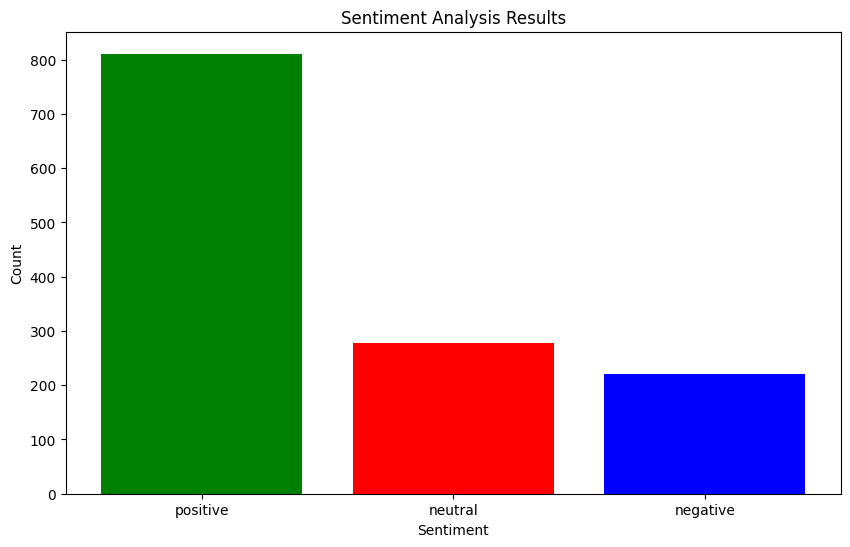

In [45]:
# Load the final CSV file
df_final = pd.read_csv('2023/sentiment_output_2023.csv')

# Count the number of each sentiment label
sentiment_counts = df_final['sentiment_label'].value_counts()

# Calculate the total number of sentiments
total_sentiments = sentiment_counts.sum()

# Calculate the percentage of each sentiment
sentiment_percentages = sentiment_counts / total_sentiments * 100

# Print the percentages
print(f"Positive: {sentiment_percentages['positive']:.2f}%")
print(f"Negative: {sentiment_percentages['negative']:.2f}%")
print(f"Neutral: {sentiment_percentages['neutral']:.2f}%")

# Create a bar plot of the sentiment counts
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')
plt.show()


#QUESTION 2

In [46]:
# Initialize the sentiment analysis pipeline with the specified model
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the cleaned reviews
train_df = pd.read_csv('2023/train_2023.tsv', sep=',')
#df_reviews = df_reviews.iloc[:600]

# Apply the pipeline to the 'comments' column to get the sentiment analysis results
train_df['sentiment_result'] = train_df['comments'].apply(lambda x: sentiment_analysis(x[:512])[0])

# Extract the sentiment label and score from the results
train_df['sentiment_label'] = train_df['sentiment_result'].apply(lambda x: x['label'])

# Create a new dataframe with the 'id', 'comments', and 'sentiment' columns
df_sentiment = df_reviews[['id', 'comments', 'sentiment_label']]

# Save the new dataframe to a CSV file
df_sentiment.to_csv('2023/train_2023.tsv', index=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



```
Χρήση train.tsv για την δημιουργία TF-IDF πίνακα και Word Embeddings
```


In [47]:
#Creation of TF-IDF matrix from the trained data of train.tsv

# Load the train.tsv file
df_train_tf = pd.read_csv('2023/train_2023.tsv', sep=',')

# Extract the 'comments' column
comments_train = df_train_tf['comments']

# Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'comments' data
tfidf_matrix_train = vectorizer.fit_transform(comments_train)

# Save the TfidfVectorizer to a pickle file
with open('2023/tfidf_vectorizer_2023.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


#Creation of wordembeddings from the trained data of train.tsv

# Load the train.tsv file
df_train_we = pd.read_csv('2023/train_2023.tsv', sep=',')

# Extract the 'comments' column
comments_train = df_train_we['comments']

# Tokenize the 'comments' data
tokenized_comments_train = [word_tokenize(comment) for comment in comments_train]

# Initialize a Word2Vec model
model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)

# Train the Word2Vec model
model.build_vocab(tokenized_comments_train)
model.train(tokenized_comments_train, total_examples=model.corpus_count, epochs=model.epochs)

# Save the Word2Vec model to a pickle file
with open('2023/word2vec_model_2023.pkl', 'wb') as f:
    pickle.dump(model, f)





#`SVM`


```
Classifier `SVM` trained by the `TF-IDF`
```


In [48]:
#Training the classifier with the tf-idf matrix

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_tf['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the SVM classifier
clf = svm.SVC(C=1.0, kernel='linear', gamma='scale')

# Train the SVM classifier using your training data
clf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.8854961832061069


```
Actual labels of test.tsv
```

In [49]:
# Load the TSV file
df_reviews = pd.read_csv('2023/test_2023.tsv', sep=',')

# Apply the pipeline to the 'comments' column to get the sentiment analysis results
df_reviews['sentiment_result'] = df_reviews['comments'].apply(lambda x: sentiment_analysis(x[:512])[0])

# Extract the sentiment label from the results
df_reviews['sentiment_label'] = df_reviews['sentiment_result'].apply(lambda x: x['label'])

# Create a new dataframe with the 'id', 'comments', and 'sentiment' columns
df_sentiment = df_reviews[['id', 'comments', 'sentiment_label']]

# Save the new dataframe to a CSV file
df_sentiment.to_csv('2023/sentiment_output2_2023.csv', index=False)


```
Classifier `SVM` trained by the `Word embeddings`
```


In [50]:
# Load the Word2Vec model
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    model = pickle.load(f)

# Convert the tokenized comments into vectors
vectorized_comments_train = [model.wv[comment] for comment in tokenized_comments_train]

# Average the word vectors for each comment to get a single vector per comment
vectorized_comments_train = [np.mean(comment, axis=0) for comment in vectorized_comments_train]

# Load the train.tsv file
df_train_we = pd.read_csv('2023/train_2023.tsv', sep=',')

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_we['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(vectorized_comments_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the SVM classifier
clf = svm.SVC(C=1.0, kernel='linear', gamma='scale')

# Train the SVM classifier using your training data
clf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.7709923664122137



```
`10-fold Cross` Validation `Word embeddings`
```


In [51]:
# Load the CSV file
df = pd.read_csv('2023/sentiment_output2_2023.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Load your word embeddings
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    word_embeddings = pickle.load(f)

# Transform the comments into word embeddings
# Transform the comments into word embeddings
X = np.array([np.mean([word_embeddings.wv[word] for word in comment.split() if word in word_embeddings.wv], axis=0) for comment in X])

# Initialize the classifier
clf = SVC(C=1.0, kernel='linear', gamma='scale')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7677537667011352 Recall: 0.7662393162393162 F1 score: 0.7153511314897624 Accuracy: 0.7662393162393162
   Precision    Recall  F1 Score  Accuracy
0   0.838384  0.777778  0.741236  0.777778
1   0.853480  0.807692  0.752005  0.807692
2   0.853480  0.807692  0.752005  0.807692
3   0.876923  0.846154  0.816239  0.846154
4   0.593407  0.692308  0.630829  0.692308
5   0.752331  0.692308  0.629863  0.692308
6   0.565934  0.730769  0.634615  0.730769
7   0.788462  0.807692  0.780886  0.807692
8   0.835165  0.769231  0.717643  0.769231
9   0.719973  0.730769  0.698190  0.730769



```
`10-fold Cross` Validation `TF-IDF`
```


In [52]:
# Load the CSV file
df = pd.read_csv('2023/sentiment_output2_2023.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Transform the comments into TF-IDF vectors
with open('2023/tfidf_vectorizer_2023.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
X = vectorizer.transform(X)

# Initialize the classifier
clf = SVC(C=1.0, kernel='linear', gamma='scale')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)


# Calculate cross-validation scores
precision = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.8462770930209441 Recall: 0.8504273504273504 F1 score: 0.8403236122787258 Accuracy: 0.8504273504273504
   Precision    Recall  F1 Score  Accuracy
0   0.890947  0.888889  0.884149  0.888889
1   0.902834  0.884615  0.870330  0.884615
2   0.881448  0.884615  0.881119  0.884615
3   0.799095  0.807692  0.801865  0.807692
4   0.850679  0.846154  0.845155  0.846154
5   0.747436  0.769231  0.746503  0.769231
6   0.724696  0.769231  0.720588  0.769231
7   0.895604  0.884615  0.888390  0.884615
8   0.925481  0.923077  0.921561  0.923077
9   0.844551  0.846154  0.843577  0.846154


#`Random Forests`


```
Classifier `Random Forests` trained by the `TF-IDF`
```


In [53]:
# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

df_train_tf = pd.read_csv('2023/train_2023.tsv', sep=',')

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_tf['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Train the Random Forest classifier using your training data
clf_rf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_rf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.8854961832061069



```
Classifier `Ramdom Forests` trained by the `Word embeddings`
```


In [54]:
# Load the Word2Vec model
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    model = pickle.load(f)

# Convert the tokenized comments into vectors
vectorized_comments_train = [model.wv[comment] for comment in tokenized_comments_train]

# Average the word vectors for each comment to get a single vector per comment
vectorized_comments_train = [np.mean(comment, axis=0) for comment in vectorized_comments_train]

# Extract the 'sentiment_label' column
sentiment_labels_train = df_sentiment['sentiment_label']

# Ensure that vectorized_comments_train and sentiment_labels_train have the same length
if len(vectorized_comments_train) != len(sentiment_labels_train):
    min_len = min(len(vectorized_comments_train), len(sentiment_labels_train))
    vectorized_comments_train = vectorized_comments_train[:min_len]
    sentiment_labels_train = sentiment_labels_train[:min_len]

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(vectorized_comments_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier using your training data
clf_rf.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_rf.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.5660377358490566



```
`10-fold Cross` Validation `Word embeddings`
```


In [55]:
# Load the CSV file
df = pd.read_csv('2023/sentiment_output2_2023.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Load your word embeddings
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    word_embeddings = pickle.load(f)

# Transform the comments into word embeddings
X = np.array([np.mean([word_embeddings.wv[word] for word in comment.split() if word in word_embeddings.wv], axis=0) for comment in X])

# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_rf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.803490986138045 Recall: 0.8047008547008547 F1 score: 0.7920892471656046 Accuracy: 0.8047008547008547
   Precision    Recall  F1 Score  Accuracy
0   0.773392  0.777778  0.760462  0.777778
1   0.799095  0.807692  0.801865  0.807692
2   0.881448  0.884615  0.881119  0.884615
3   0.902834  0.884615  0.870330  0.884615
4   0.755061  0.769231  0.751648  0.769231
5   0.765352  0.730769  0.720652  0.730769
6   0.744344  0.769231  0.750962  0.769231
7   0.805882  0.807692  0.801622  0.807692
8   0.801619  0.807692  0.782554  0.807692
9   0.805882  0.807692  0.799679  0.807692



```
`10-fold Cross` Validation `TF-IDF`
```


In [56]:
# Load the CSV file
df = pd.read_csv('2023/sentiment_output2_2023.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Transform the comments into TF-IDF vectors
with open('2023/tfidf_vectorizer_2023.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
X = vectorizer.transform(X)

# Initialize the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_rf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_rf, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.8663083716392539 Recall: 0.8582621082621082 F1 score: 0.8516548328382523 Accuracy: 0.8582621082621082
   Precision    Recall  F1 Score  Accuracy
0   0.874074  0.851852  0.856673  0.851852
1   0.923077  0.923077  0.923077  0.923077
2   0.893040  0.884615  0.887192  0.884615
3   0.893040  0.884615  0.887192  0.884615
4   0.850679  0.846154  0.845155  0.846154
5   0.791101  0.807692  0.790865  0.807692
6   0.817308  0.769231  0.714286  0.769231
7   0.895604  0.884615  0.888390  0.884615
8   0.925481  0.923077  0.921561  0.923077
9   0.799679  0.807692  0.802157  0.807692


#`KNN`


```
Classifier `KNN` trained by the `TF-IDF`
```


In [57]:
# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

df_train_tf = pd.read_csv('2023/train_2023.tsv', sep=',')

# Extract the 'sentiment_label' column
sentiment_labels_train = df_train_tf['sentiment_label']

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Train the KNN classifier using your training data
clf_knn.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_knn.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.7938931297709924



```
Classifier `KNN` trained by the `Word embeddings`
```


In [58]:
# Load the Word2Vec model
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    model = pickle.load(f)

# Convert the tokenized comments into vectors
vectorized_comments_train = [model.wv[comment] for comment in tokenized_comments_train]

# Average the word vectors for each comment to get a single vector per comment
vectorized_comments_train = [np.mean(comment, axis=0) for comment in vectorized_comments_train]

# Extract the 'sentiment_label' column
sentiment_labels_train = df_sentiment['sentiment_label']

# Ensure that vectorized_comments_train and sentiment_labels_train have the same length
if len(vectorized_comments_train) != len(sentiment_labels_train):
    min_len = min(len(vectorized_comments_train), len(sentiment_labels_train))
    vectorized_comments_train = vectorized_comments_train[:min_len]
    sentiment_labels_train = sentiment_labels_train[:min_len]

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(vectorized_comments_train, sentiment_labels_train, test_size=0.2, random_state=42)

# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier using your training data
clf_knn.fit(X_train, y_train)

# Evaluate the classifier on your validation data
accuracy = clf_knn.score(X_val, y_val)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.41509433962264153



```
`10-fold Cross` Validation `Word embeddings`
```


In [59]:
# Load the CSV file
df = pd.read_csv('2023/sentiment_output2_2023.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Load your word embeddings
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    word_embeddings = pickle.load(f)

# Transform the comments into word embeddings
X = np.array([np.mean([word_embeddings.wv[word] for word in comment.split() if word in word_embeddings.wv], axis=0) for comment in X])

# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_knn, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.8133810149115878 Recall: 0.8047008547008547 F1 score: 0.7925797155337855 Accuracy: 0.8047008547008547
   Precision    Recall  F1 Score  Accuracy
0   0.787037  0.777778  0.762225  0.777778
1   0.802941  0.807692  0.797358  0.807692
2   0.902834  0.884615  0.870330  0.884615
3   0.902834  0.884615  0.870330  0.884615
4   0.805128  0.807692  0.800729  0.807692
5   0.659799  0.653846  0.649313  0.653846
6   0.756410  0.769231  0.752758  0.769231
7   0.846154  0.846154  0.833877  0.846154
8   0.855769  0.807692  0.780830  0.807692
9   0.814904  0.807692  0.808047  0.807692



```
`10-fold Cross` Validation `TF-IDF`
```


In [60]:
# Load the CSV file
df = pd.read_csv('2023/sentiment_output2_2023.csv')

# Prepare the features and the target variable
X = df['comments']
y = LabelEncoder().fit_transform(df['sentiment_label'])

# Transform the comments into TF-IDF vectors
with open('2023/tfidf_vectorizer_2023.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
X = vectorizer.transform(X)

# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Calculate cross-validation scores
precision = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1, average='weighted'))
recall = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1, average='weighted'))
f1 = cross_val_score(clf_knn, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1, average='weighted'))
accuracy = cross_val_score(clf_knn, X, y, cv=cv, scoring='accuracy')

# Print the average scores
print(f'Precision: {precision.mean()}',f'Recall: {recall.mean()}',f'F1 score: {f1.mean()}',f'Accuracy: {accuracy.mean()}')

# Create a dictionary with the scores
scores = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

# Create a DataFrame from the dictionary
df_scores = pd.DataFrame(scores)

# Print the DataFrame
print(df_scores)

Precision: 0.7652173871497917 Recall: 0.774074074074074 F1 score: 0.7484022926057239 Accuracy: 0.774074074074074
   Precision    Recall  F1 Score  Accuracy
0   0.728395  0.740741  0.708642  0.740741
1   0.747863  0.769231  0.752941  0.769231
2   0.839744  0.846154  0.835294  0.846154
3   0.678632  0.730769  0.694822  0.730769
4   0.661538  0.692308  0.661783  0.692308
5   0.793590  0.807692  0.788462  0.807692
6   0.788462  0.807692  0.780886  0.807692
7   0.710407  0.730769  0.714904  0.730769
8   0.855769  0.807692  0.780830  0.807692
9   0.847773  0.807692  0.765460  0.807692


**Αξιολόγηση Ταξινομητών**:<br/><br/>

**SVM:**
Σύμφωνα με τα αποτελέσματα η μέθοδος με την χρήση TF-IDF είναι καλύτερη απο την χρήση της μεθόδου Word embeddings όσον αφορά τις τιμές των Precision, Recall, F1 Score, and Accuracy. Συγκεκριμένα η μέθοδος Word embeddings έχει κατά μέσο όρο για τις τιμές αυτές αντίστοιχα 0.74,  0.79,  0.73,  0.79, ενώ η μέθοδος TF-IDF έχει για τις τιμές αυτές αντίστοιχα κατά μέσο όρο 0.85, 0.84, 0.82, 0.84 . Οπότε οι επιδόσεις της μεθόδου με τον πίνακα TF-IDF φαίνεται να είναι καλύτερες καθιστώντας την πιο αξιόπιστη στον ταξινομητή αυτόν.<br/><br/>

**Random Forests:**
Σύμφωνα με τα αποτελέσματα η μέθοδος με την χρήση TF-IDF είναι καλύτερη απο την χρήση της μεθόδου Word embeddings όσον αφορά τις τιμές των Precision, Recall, F1 Score, and Accuracy. Συγκεκριμένα η μέθοδος Word embeddings έχει κατά μέσο όρο για τις τιμές αυτές αντίστοιχα 0.77,  0.79,  0.77,  0.79, ενώ η μέθοδος TF-IDF έχει για τις τιμές αυτές αντίστοιχα κατά μέσο όρο 0.86, 0.85, 0.85, 0.85 . Οπότε οι επιδόσεις της μεθόδου με τo TF-IDF φαίνεται να είναι καλύτερες καθιστώντας την πιο αξιόπιστη στον ταξινομητή αυτόν.<br/><br/>

**KNN**:
Σύμφωνα με τα αποτελέσματα η μέθοδος με την χρήση TF-IDF είναι καλύτερη απο την χρήση της μεθόδου Word embeddings όσον αφορά τις τιμές των Precision, Recall, F1 Score, and Accuracy. Συγκεκριμένα η μέθοδος Word embeddings έχει κατά μέσο όρο για τις τιμές αυτές αντίστοιχα  0.72,  0.77,  0.73,  0.77, ενώ η μέθοδος TF-IDF έχει για τις τιμές αυτές αντίστοιχα κατά μέσο όρο 0.74,  0.79,  0.73, 0.79 . Οπότε οι επιδόσεις της μεθόδου με το Word Embeddings φαίνεται να είναι καλύτερες καθιστώντας την πιο αξιόπιστη στον ταξινομητή αυτόν.<br/><br/>

Επομένως προκύπτει ότι ο καταλληλότερος και πιο αξιόπιστος γιαυτά τα δεδομένα ταξινομητής είναι ο Random Forests με την χρήση πίνακα TF-IDF.

#QUESTION 3

In [71]:
# Loading the pretrained Word2Vec model
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    model = pickle.load(f)

# Function to calculate cosine similarity
def cosine_similarity(v1, v2):
    return 1 - cosine(v1, v2)

# Function to find the semantic neighborhood of a word
def get_neighborhood(word, N, words):
    most_similar_words = model.wv.most_similar(word, topn=N*100)

    neighbourhood = [word for word, _ in most_similar_words if word in words]

    if len(neighbourhood) > N:
      neighbourhood = neighbourhood[:N]

    return neighbourhood

# Function to calculate the similarity based on the maximum similarity of the neighborhoods
def max_similarity_of_neighborhoods(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2):
    max_sim1 = 0
    max_sim2 = 0

    for word in neighborhood1:
        sim = similarity_matrix[words.index(word2)][words.index(word)]
        if sim > max_sim2:
          max_sim2 = sim

    for word in neighborhood2:
        sim = similarity_matrix[words.index(word1)][words.index(word)]
        if sim > max_sim1:
          max_sim1 = sim

    if max_sim1 > max_sim2:
      return max_sim1
    else:
      return max_sim2

# Function to calculate the similarity based on the correlation of the similarities of the neighborhoods
def correlation_of_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix):
    sims1 = [similarity_matrix[words.index(word)][words.index(neighborhood1[0])] for word in neighborhood1]
    sims2 = [similarity_matrix[words.index(word)][words.index(neighborhood2[0])] for word in neighborhood2]
    return np.corrcoef(sims1, sims2)[0, 1]

# Function to calculate the similarity based on the sum of the squares of the similarities of the neighborhoods
def sum_of_squared_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2):
    max_sim1 = 0
    max_sim2 = 0

    for word in neighborhood1:
        sim = similarity_matrix[words.index(word2)][words.index(word)]
        max_sim2 = max_sim2 +  sim ** 2

    for word in neighborhood2:
        sim = similarity_matrix[words.index(word1)][words.index(word)]
        max_sim1 = max_sim1 +  sim ** 2

    return np.sqrt((max_sim1 + max_sim2))

# Main function that combines all of the above
def compute_similarities(word1, word2, N, words, similarity_matrix):
    neighborhood1 = get_neighborhood(word1, N, words)
    neighborhood2 = get_neighborhood(word2, N, words)

    max_sim = max_similarity_of_neighborhoods(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2)
    corr_sim = correlation_of_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix)
    sum_squares_sim = sum_of_squared_neighborhood_similarities(neighborhood1, neighborhood2, words, similarity_matrix, word1, word2)

    return {
        'max_similarity_of_neighborhoods': max_sim,
        'correlation_of_neighborhood_similarities': corr_sim,
        'sum_of_squared_neighborhood_similarities': sum_squares_sim
    }

In [72]:
# Loading the pretrained Word2Vec model
with open('2023/word2vec_model_2023.pkl', 'rb') as f:
    model = pickle.load(f)

df = pd.read_csv('2023/reviews_output_2023.csv')

# Flatten the list of words in the 'comments' column
words = [word for sublist in df['comments'].str.split() for word in sublist]

# Count the frequency of each word
word_count = Counter(words)

# Get the 300 most common words
most_common_words = dict(word_count.most_common(300))

# Get the list of the 300 most common words
words = list(most_common_words.keys())
print(words)

# Create a matrix where each row is the Word2Vec vector of a word
word_vectors = np.array([model.wv[word] for word in words if word in model.wv])

# Calculate the cosine similarity matrix
similarity_matrix = sklearn_cosine_similarity(word_vectors)

N = int(input("Give the N: "))

while True:
    word1 = input("Enter the first word: ")
    word2 = input("Enter the second word: ")

    if word1 in words and word2 in words:
        similarities = compute_similarities(word1, word2, N, words, similarity_matrix)
        print(similarities)

        neighborhood = get_neighborhood(word1, N, words)
        print(f"The {N}-neighborhood of the word '{word1}' is: {neighborhood}")
        neighborhood = get_neighborhood(word2, N, words)
        print(f"The {N}-neighborhood of the word '{word2}' is: {neighborhood}")
        break
    else:
        print("One or both of the words are not in the dictionary. Please enter new words.")

['br', 'apartment', 'place', 'stay', 'anna', 'athens', 'host', 'u', 'great', 'everything', 'location', 'day', 'clean', 'nice', 'arrival', 'close', 'metro', 'really', 'would', 'reservation', 'toula', 'canceled', 'automated', 'posting', 'time', 'perfect', 'need', 'recommend', 'good', 'well', 'also', 'even', 'helpful', 'easy', 'station', 'city', 'restaurant', 'flat', 'comfortable', 'ilias', 'walk', 'walking', 'get', 'definitely', 'home', 'thanks', 'wonderful', 'view', 'acropolis', 'distance', 'thank', 'located', 'needed', 'around', 'made', 'area', 'highly', 'amazing', 'lot', 'minute', '2', 'best', 'like', 'night', 'kind', 'go', 'one', 'lovely', 'back', 'center', 'make', 'central', 'could', 'check', 'experience', 'little', 'away', 'friend', 'house', 'friendly', 'visit', 'excellent', 'much', 'next', 'staying', 'airport', 'want', 'feel', 'super', 'quiet', 'near', 'sure', 'thing', 'gave', 'shop', 'room', 'two', '5', 'always', 'stayed', 'help', '3', 'see', 'syntagma', 'angeliki', 'come', 'site

Η παράμετρος N (μέγεθος της γειτονιάς) δεν επηρεάζει τις τιμές του max similarity και του sum of squared similarities, ωστόσο διαφέρει το correlation. Αυξάνοντας την τιμή του N, εξετάζεται μεγαλύτερος αριθμός γειτονικών λέξεων, πράγμα που μπορεί να αυξάνει την πιθανότητα να βρεθούν λέξεις με υψηλή ομοιότητα. Ωστόσο, αυτό μπορεί επίσης να περιλαμβάνει περισσότερες λέξεις που δεν είναι στενά συνδεδεμένες, μειώνοντας την ομοιότητα. Επομένως, η επίδραση της αλλαγής του N εξαρτάται από την ειδική δομή του σημασιολογικού χώρου.